In [1]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv

# Load from env
load_dotenv()

model = init_chat_model("gpt-4o-mini")

In [2]:
from pathlib import Path
import sys
# append dev directory to sys.path
sys.path.insert(0, str(Path.cwd().parent / "agent"))

In [3]:

# Import the data exploration agent
from data_exploration_subagent import build_agent as build_data_exploration_agent
from langchain.tools import tool

# Build the data exploration agent
data_exploration_agent = build_data_exploration_agent()

# Wrap data_exploration_agent as a tool
@tool("database_exploration_agent", description="Use this agent to explore and query the art database. Provide a natural language question about the art data.")
def call_data_exploration_agent(query: str) -> str:
    """
    Call the database exploration agent to answer questions about the art database.
    
    Args:
        query: A natural language question about the art data
        
    Returns:
        The response from the data exploration agent
    """
    result = data_exploration_agent.invoke(
        {"messages": [{"role": "user", "content": query}]}
    )
    return result["messages"][-1].content

In [4]:
# Image qna tools for main_agent
# import importlib
# import sys

# # Ensure fresh import
# if 'image_qna_tool' in sys.modules:
#     importlib.reload(sys.modules['image_qna_tool'])

from image_qna_tool import build_image_qna_tool
image_qna_tool = build_image_qna_tool()

/home/afiq/fyp/fafa-repo/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
tools = [
    image_qna_tool,
    call_data_exploration_agent,
]

tools_by_name = {tool.name: tool for tool in tools}


In [6]:
from typing import Annotated, Any, Dict, List
from langgraph.graph import MessagesState

# Reducer 
def merge_tool_results(a: dict, b: dict) -> dict:
    return {**a, **b}

# 
# class PlanStep(TypedDict):
#     id: int
#     tool: str
#     description: str

# Main agent state
class MainAgentState(MessagesState):
    """Main agent state."""
    base_plan: List[str] = []
    current_step: int = 0
    step_history: List[str] = []
    replan_count: int = 0
    feedback: str | None = None
    replan_approval: bool = False

    # from data_exploration_subagent
    tool_results: Annotated[Dict[str, Any], merge_tool_results]

In [7]:
# helper
def format_tools_for_prompt(tools):
    lines = []
    for i, tool in enumerate(tools, start=1):
        lines.append(f"{i}. {tool.name}: {tool.description}")
    return "\n".join(lines)

import re

def parse_plan(plan_text: str) -> list[str]:
    """
    Converts a numbered plan string into a list of steps.
    """
    # Split on line breaks and remove empty lines
    lines = [line.strip() for line in plan_text.split("\n") if line.strip()]
    
    steps = []
    for line in lines:
        # Remove the number + dot prefix (e.g., "1. ", "2. ")
        step = re.sub(r"^\d+\.\s*", "", line)
        steps.append(step)
    
    return steps


def plan_and_list_tasks(state: MainAgentState):
    """Plan and list tasks."""
    planning_system_prompt = """
    You are an efficient task planner. Your job is to only plan and list tasks or subtasks in the most efficient and resourceful way.
    You are given a user query/task and a list of tools.
    
    list the tasks in the following format:
    1. task 1
    2. task 2
    3. task 3
    ...

    plan and list the tasks in a way that each task can be solved by one of these tools.

    tools:
    1. image_qna_tool: This tool equipped with a visual question answering model that can answer questions related to the images in the database.
    2. database_exploration_agent: This tool can answer questions related to the database but limited to the scope of the schema.

    tools_description:
    {tools}    
    """

    replanning_system_prompt = """
    You are an efficient task planner. Your job is to only plan and list tasks or subtasks in the most efficient and resourceful way.
    
    your plan seems to have issues:
    {feedback}

    please replan the tasks.
    current_plan:
    {base_plan}

    tools_description:
    {tools}
    """
    
    if state.get("feedback") is not None: # replan
        replanning_system_prompt = replanning_system_prompt.format(
            feedback=state["feedback"],
            base_plan="\n".join(state["base_plan"]),
            tools=format_tools_for_prompt(tools)
        )
        response = model.invoke(
                [
                    {"role": "system", "content": replanning_system_prompt},
                    {"role": "user", "content": state["messages"][-1].content},
                ]
            )
        state_update = {
                "base_plan": parse_plan(response.content),
                "current_step": 0,
                "replan_count": state["replan_count"] + 1
            }

        # Return updated state
        return state_update
    
    response = model.invoke(
            [
                {"role": "system", "content": planning_system_prompt.format(
                    tools=format_tools_for_prompt(tools)
                )},
                {"role": "user", "content": state["messages"][-1].content},
            ]
        )

    state_update = {
            "base_plan": parse_plan(response.content),
            "current_step": 0,
            "replan_count": 0
        }

    # Return updated state
    return state_update


In [ ]:
from typing import Literal
from langgraph.graph import END, MessagesState
from langchain_core.messages import AIMessage, ToolMessage

# Node: Process user query with main agent
main_agent_system_prompt = """
You are a helpful assistant designed to solve tasks/ question about the art database.
You have access to a specialized data exploration agent that can query the art database.
You also have access to a tool that can answer questions related to the images in the database.

Your limitation in data exploration agent is that it can only query the database and tasks that demands context outside the database schema are beyond its scope.

When users ask questions about the art database, use the data_exploration_agent tool to find the answers, if the schema and context relates.
When users ask questions in regard to the visuals in the images, use the image_qna_tool to solve the tasks.

You can ask the agent multi-step questions and use the results to provide comprehensive responses.
"""

def process_query(state: MainAgentState):
    """Process user query with the main agent."""

    # if has feedback go straight to replan, will implement later
    if state.get("feedback") is not None:
        return state

    # Safety check: do we have any steps left?
    if state["current_step"] >= len(state["base_plan"]):
        print(f"All steps completed. Current step: {state['current_step']}, Total steps: {len(state['base_plan'])}")
        return {"messages": state["messages"]}  # return current messages unchanged

    # Get the current plan step
    current_step_text = state["base_plan"][state["current_step"]]
    # current_step_text = state.base_plan[state.current_step]

    # System + user messages
    system_message = {"role": "system", "content": main_agent_system_prompt}
    plan_message = {"role": "user", "content": f"Execute the following step: {current_step_text}"}

    # Bind tools the agent can use
    llm_with_tools = model.bind_tools([image_qna_tool, call_data_exploration_agent])

    # Include previous messages for context
    response = llm_with_tools.invoke([system_message] + state["messages"] + [plan_message])

    # Track the step in history
    new_step_history = state["step_history"].copy() if state.get("step_history") else {}
    new_step_history[state["current_step"]] = current_step_text

    # Increment the current_step after producing the tool call
    new_current_step = state["current_step"] + 1
    
    # Append response to messages (not replace)
    new_messages = state["messages"] + [response]

    return {
        "messages": new_messages,
        "current_step": new_current_step,
        "step_history": new_step_history
    }


def tool_node(state: MainAgentState):
    """Performs the tool call."""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        try:
            observation = tool.invoke(tool_call["args"])

        except Exception as e:
            observation = f"Error: {e}"
            feedback = f"Error on Tool {tool_call['name']}, Error: {e}"
            result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
            return {"messages": result, "feedback": feedback}

        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

from langgraph.types import Command, interrupt
def interrupt_for_replan(state: MainAgentState) -> Command[Literal["plan_and_list_tasks", "cleanup"]]:

    is_approved = interrupt({
        "question": "Do you want to proceed with replanning?",
    }) 

    if is_approved:
        return Command(goto="plan_and_list_tasks")
    else:
        return Command(goto="cleanup")

    # return interrupt(
    #     {
    #         "reason": "replan_required",
    #         "feedback": state.get("feedback"),
    #         "current_plan": state.get("base_plan"),
    #     }
    # )

# Conditional edge function
def should_continue(state: MainAgentState) -> Literal["cleanup", "tool_execution", "interrupt_for_replan"]:
    """Determine if we should call the agent or end."""
    # Check for replan
    if state.get("feedback") is not None:
        return "interrupt_for_replan"

    messages = state["messages"]
    last_message = messages[-1]

    # Check if we have reached the end of the plan
    if state["current_step"] > len(state["base_plan"]):
        return "cleanup"
    if not getattr(last_message, "tool_calls", None):
        return "cleanup"
    else:
        return "tool_execution"
    
# cleanup Node
def cleanup_state(state: MainAgentState) -> MainAgentState:
    return {
        **state,
        "base_plan": None,
        "current_step": 0,
        "step_history": None,
        "replan_count": 0,
        "feedback": None
    }



In [19]:
from langgraph.graph import START, StateGraph


# Build the main agent graph
def build_main_agent():
    """Build the main agent graph with data exploration agent as subagent."""
    builder = StateGraph(MainAgentState)
    builder.add_node("plan_and_list_tasks", plan_and_list_tasks)
    builder.add_node("process_query", process_query)
    builder.add_node("tool_execution", tool_node)
    builder.add_node("cleanup", cleanup_state)
    builder.add_node("interrupt_for_replan", interrupt_for_replan)
    
    builder.add_edge(START, "plan_and_list_tasks")
    builder.add_edge("plan_and_list_tasks", "process_query")
    builder.add_conditional_edges(
        "process_query",
        should_continue,
    )
    builder.add_edge("tool_execution", "process_query")
    builder.add_edge("interrupt_for_replan", "plan_and_list_tasks")
    builder.add_edge("cleanup", END)
    
    return builder.compile()


# Initialize the main agent
main_agent = build_main_agent()

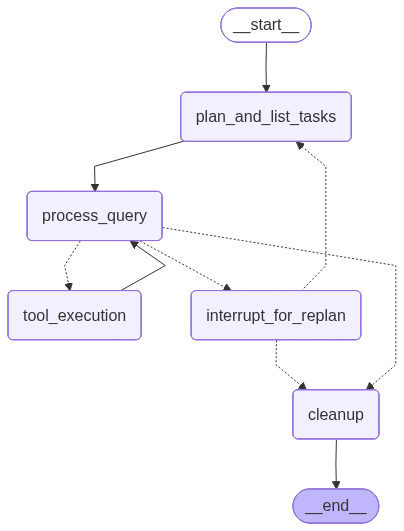

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(main_agent.get_graph().draw_mermaid_png()))

In [21]:
questions = [
    "Which genre has the oldest painting?",
    # "How many paintings are there from the Renaissance period?",
    # "What is shown in the painting image with the oldest year?",
    # "Get the century of the newest painting per genre.",
    # "Plot the number of paintings for each year.",
    # "Get the number of swords shown in oldest paintings from the Renaissance period.",
]

from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()
config = {"configurable": {"thread_id": "dev-fyp"}}

for question in questions:
    print(f"\nQuestion: {question}")
    print("-" * 50)
    
    for step in main_agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values",
        config=config,
        checkpoint=checkpointer,
    ):
        step["messages"][-1].pretty_print()


Question: Which genre has the oldest painting?
--------------------------------------------------
================================ Human Message =================================

Which genre has the oldest painting?
================================ Human Message =================================

Which genre has the oldest painting?
================================== Ai Message ==================================
Tool Calls:
  database_exploration_agent (call_MFvVW6Gkb56V1IOp88uO75M5)
 Call ID: call_MFvVW6Gkb56V1IOp88uO75M5
  Args:
    query: What is the genre of the oldest painting in the art database?
================================= Tool Message =================================

The genre of the oldest painting in the art database is **religious art**.
All steps completed. Current step: 1, Total steps: 1
================================= Tool Message =================================

The genre of the oldest painting in the art database is **religious art**.
=====================